In [2]:
import os; 
import pandas as pd; pd.set_option('mode.chained_assignment',None)
import numpy as np
import datetime
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import math
import re
import xlrd
import statistics as stat
from xlsxwriter.utility import xl_rowcol_to_cell
from random import sample
from src.data_models.SmartsCsvDataModel import SmartsCsvDataModel
from src.data_models.smartshelper import metrics, fixNum, unSMART, cparty, wtf, textfunc, identities
from src.data_models.SmartsDataModel import SmartsDataModel
from src.utility.DataModelUtility import execute_query_data_frame
from src.data_models.SmartsDataModel import SmartsDataModel
from src.data_models.UPMhelper import UPMalerts

/Users/sqian/.pyenv/versions/3.7.0/envs/env_370/lib/python3.7/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [16]:
query = """select 
trading_pair, account_id, sum(quantity) as quantity, sum(price*quantity)/sum(quantity) as avgprice
from order_fill_event
where created::date = '2019-08-14' and trading_pair = 'BCHETH' and side = 'sell'
group by trading_pair, account_id
order by sum(price*quantity)/sum(quantity) desc;"""

pdescalation = execute_query_data_frame(query,'engine')

INFO:paramiko.transport:Connected (version 2.0, client OpenSSH_7.4p1)
INFO:paramiko.transport:Authentication (publickey) successful!


ssh_connect 0:00:00.579196


INFO:root:Loaded dataframe with 6 rows in 0:00:15.974582.


In [17]:
pdescalation

,trading_pair,account_id,quantity,avgprice
0,BCHETH,379107,0.005830,1.726000
1,BCHETH,711292,36.345574,1.676000
2,BCHETH,44498,5.068173,1.675902
3,BCHETH,568127,7.424950,1.669272
4,BCHETH,202474,1.840000,1.669150
5,BCHETH,237320,818.654676,1.620053


#### >>> 0) Alerting Period

In [2]:
alerting_1 = datetime.date(2019,8,1)
alerting_2 = datetime.date(2019,8,31)

#### >>> 1) Import

In [3]:
alerts00 = unSMART(pd.read_excel('~/Documents/vmfldr/smarts1_{}.xlsx'.format(alerting_1.strftime("%Y%b"))))
alerts0 = alerts00.loc[~alerts00['AlertCode'].isin([4041,4042])]

washcases = pd.read_excel('/Users/sqian/Documents/{}_output/{}_Wash.xlsx'.format(alerting_1.strftime("%Y%m"), alerting_1.strftime("%Y%b")), sheet_name = 'f.F')['Unnamed: 0'][-1:].get_values()[0]

-> type fixed, kept 179 rows, 12 columns


#### >>> 2) Case Creation Step 1: Case Group Level Division

In [4]:
alertgroupmap1 = {1001:'group1', 4009:'group1', 4012:'group1', 4045:'group2', 2011:'group3', 4022:'group4', 4023:'group4', 4032:'group4', 4042:'wash'}

alerts0['Case'] = alerts0['AlertCode'].map(alertgroupmap1)
grouplist = alerts0['Case'].value_counts().index.tolist(); grouplist.sort()

#### >>> 3) Case Creation Step 2: Account Level Division

In [5]:
codeabb_map = {1001:'UPM', 2011:'UVM', 4012:'UPM', 4045:'Collusion', 4022:'Spoof', 4032:'Spoof', 4023:'Spoof', 4041:'wash', 4042:'wash', 4009:'UPM'}
uniquecase_map = pd.DataFrame()

for i in grouplist:
    subset = alerts0.loc[alerts0['Case'] == i,['AlertCode','AccountIDName','AlertID']]
    subset['group'] = subset['AlertCode'].map(codeabb_map)
    
    temp_groupby = subset.groupby(['group','AccountIDName'])
    temp_count = pd.DataFrame(temp_groupby.count()).rename(columns={'AlertID':'instances'})['instances']
    temp_min = pd.DataFrame(temp_groupby.min())['AlertCode'].rename(columns={'AlertCode':'min'})
    temp_max = pd.DataFrame(temp_groupby.max())['AlertCode'].rename(columns={'AlertCode':'max'})
    temp = pd.concat([temp_count, temp_min, temp_max],axis=1).reset_index(drop=False).rename(columns={0:'min',1:'max'})
    temp['score'] = temp['min'].floordiv(1000) + temp['max'].floordiv(1000)
    if i == 'group1':
        temp2 = temp.sort_values(['instances','score','AccountIDName'],ascending=False)
    else:
        temp2 = temp.sort_values(['instances'],ascending=False)
    uniquecase_map = uniquecase_map.append(temp2)

uniquecase_map = uniquecase_map.reset_index(drop=False).rename(columns={'index':'instanceBYcode'}).reset_index(drop=False).rename(columns={'index':'Case'})
uniquecase_map['Case'] = uniquecase_map['Case'] + washcases
uniquecase_map['Case0'] = 'Case ' + (uniquecase_map['Case'] + 1).astype(str).apply(lambda x: '{0:0>2}'.format(x))
uniquecase_map['CaseName'] = uniquecase_map['group'] + ' (' + alerting_1.strftime("%Y%b") + alerting_1.strftime("%b") + ') - ' + uniquecase_map['Case0'] + ' - ' + uniquecase_map['AccountIDName'].astype(str) 
uniquecase_map['CaseMap'] = uniquecase_map['group'].astype(str) + '|' + uniquecase_map['AccountIDName'].astype(str)

/Users/sqian/.pyenv/versions/3.7.0/envs/env_370/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/Users/sqian/.pyenv/versions/3.7.0/envs/env_370/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/Users/sqian/.pyenv/versions/3.7.0/envs/env_370/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will r

#### >>> 4) Alert Table

In [6]:
casemap = uniquecase_map[['CaseMap','CaseName']].set_index('CaseMap').to_dict('series')['CaseName']
casemapNo = uniquecase_map[['CaseMap','Case0']].set_index('CaseMap').to_dict('series')['Case0']

allalerts = alerts0[['AlertCode', 'Datetime', 'InstrumentCode', 'AccountIDName','LongText','ShortText','ShortText_mod']]
allalerts['group'] = allalerts['AlertCode'].map(codeabb_map)

allalerts['CaseMap'] = allalerts['group'] + '|' + allalerts['AccountIDName'].astype(str)
allalerts['CaseName'] = allalerts['CaseMap'].map(casemap)
allalerts['CaseNo'] = allalerts['CaseMap'].map(casemapNo)

finaltable = allalerts.sort_values('CaseNo').reset_index(drop=True)

#### >>> 5) Case Table

In [7]:
cases = finaltable.reset_index().groupby(['CaseNo','CaseName'])

df_Case = pd.DataFrame(cases['CaseNo'].count())
df_AlertCode = pd.DataFrame(cases['AlertCode'].apply(pd.unique))
df_Security = pd.DataFrame(cases['InstrumentCode'].apply(pd.unique))
df_count = pd.DataFrame(cases['index'].apply(pd.unique).apply(len))
df_count.columns = ['noAlerts']

df0 = pd.concat([df_Case,df_AlertCode,df_Security,df_count],axis=1)
df = df0.drop(columns='CaseNo').reset_index()

#### >>> 6) FULL Case Table including Wash Cases

In [8]:
eventm = pd.read_excel('/Users/sqian/Documents/{}_output/{}_Wash.xlsx'.format(alerting_1.strftime("%Y%m"), alerting_1.strftime("%Y%b")), sheet_name = 'EventMapping')
eventm['AlertCode'] = eventm['AlertID'].str.extract('.*\((.*)\).*').astype(int)

washgrouping = eventm.groupby(['CaseNo'])
Security = washgrouping['Security'].apply(pd.unique)
noAlerts = washgrouping['AlertID'].apply(pd.unique).apply(len)
noCode = washgrouping['AlertCode'].apply(pd.unique)

washcasesTables = pd.concat([Security,noAlerts,noCode],axis=1).reset_index().rename(columns={'Description':'CaseName','AlertID':'noAlerts'})
CaseTable = washcasesTables.append(df.rename(columns={'InstrumentName':'Security'}),sort=False)[df.rename(columns={'InstrumentName':'Security'}).columns.tolist()].reset_index(drop=True)

#### >>> 7) Unusual Price Movement Exhibits

In [9]:
upmgroup = [1001,4009,4011,4012]
fig_Aint = pd.DataFrame(finaltable.groupby([finaltable['Datetime'].dt.month,'AlertCode']).count()['CaseNo']).reset_index(drop=False).rename(columns={'Datetime':'month','CaseNo':'Alerts'})
fig_A = pd.pivot_table(fig_Aint.loc[fig_Aint['AlertCode'].isin(upmgroup)], values='Alerts', index=['month'], columns=['AlertCode'], aggfunc=np.sum)
fig_A['TOTAL'] = fig_A.sum(axis=1)

In [10]:
date_list = [alerting_1 + datetime.timedelta(days=x) for x in range(0, 30)]
datePD = pd.DataFrame(date_list).set_index(0)
data = pd.DataFrame(finaltable['Datetime'].dt.date.value_counts())
plotdata = pd.concat([datePD,data['Datetime']],axis=1,sort=True).fillna(0).astype(int)

os.chdir('/Users/sqian/Documents/{}_output'.format(alerting_1.strftime("%Y%m")))
plt.rcParams['figure.figsize'] = (12,4)
plt.plot_date(x=plotdata.index, y=plotdata['Datetime'], fmt="go-",xdate=True)
plt.ylabel("Number of Alerts")
plt.title("{} - {}: UPM Group Alert Events".format(alerting_1.strftime("%Y/%m/%d"),alerting_2.strftime("%Y/%m/%d")))
plt.grid(True)
plt.savefig("{}_UPM_fig_B.png".format(alerting_1.strftime("%Y%b")))
plt.close()

/Users/sqian/.pyenv/versions/3.7.0/envs/env_370/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


In [11]:
UPMtable = finaltable.loc[finaltable['AlertCode'].isin([1001])][['CaseNo', 'AlertCode', 'Datetime', 'InstrumentCode', 'AccountIDName', 'LongText']]

countpercase = UPMtable.groupby('CaseNo').count()['AlertCode']
mindt = UPMtable.groupby('CaseNo')['Datetime'].min()
maxdt = UPMtable.groupby('CaseNo')['Datetime'].max()
sec = UPMtable.groupby('CaseNo')['InstrumentCode'].apply(pd.unique)
ltext = UPMtable.groupby('CaseNo')['LongText'].apply(pd.unique)

output0 = pd.concat([countpercase, mindt, maxdt, sec, ltext], axis=1)
output0.columns = ['countpercase', 'mindt', 'maxdt', 'sec', 'ltext']
output0['text'] = 'blank'
output = output0.reset_index()

In [12]:
casenamemap = df[['CaseNo','CaseName']].set_index('CaseNo').to_dict()['CaseName']

In [13]:
casenamemap = df[['CaseNo','CaseName']].set_index('CaseNo').to_dict()['CaseName']
text3 = '{} includes {} Unusual Price Movement (1001) Alert, triggered on {} on security {} which reads as follows:'

for i in output['CaseNo']:
    count = output.loc[output['CaseNo'] == i,'countpercase'].get_values()[0]
    dt_min = pd.to_datetime(output.loc[output['CaseNo'] == i,'mindt'].get_values())[0].strftime("%B %d, %Y at %H:%M:%S.%f")
    sec = output.loc[output['CaseNo'] == i,'sec'].get_values()[0][0]
    output.loc[output['CaseNo'] == i,'text'] = text3.format(i, count, dt_min, sec)
    
output['CaseName'] = output['CaseNo'].map(casenamemap)
fig_X0 = output[['CaseNo','CaseName','sec','text','ltext']]

#### >>> 8) Price Driver Exhibits

##### >>>> Segregation

In [14]:
PD_bool = df.loc[df['AlertCode'].astype(str).isin(['[1001 4012]','[4012]'])].reset_index(drop=True)
PD_table = finaltable.loc[finaltable['CaseNo'].isin(pd.unique(PD_bool['CaseNo']).tolist())][['CaseNo', 'AlertCode', 'Datetime', 'InstrumentCode', 'AccountIDName', 'LongText']]

alertacc = PD_table.groupby('CaseNo')['AccountIDName'].apply(pd.unique).astype(str).str.replace('[','').str.replace(']','').astype(int)
countpercase = PD_table.groupby('CaseNo').count()['AlertCode']
mindt = PD_table.groupby('CaseNo')['Datetime'].min().dt.date
maxdt = PD_table.groupby('CaseNo')['Datetime'].max().dt.date
sec = PD_table.groupby('CaseNo')['InstrumentCode'].apply(pd.unique)
ltext = PD_table.groupby('CaseNo')['LongText'].apply(pd.unique)

PD_output0 = pd.concat([alertacc, countpercase, mindt, maxdt, sec, ltext], axis=1)
PD_output0.columns = ['account', '#alerts', 'mindt', 'maxdt', 'sec', 'ltext']
PD_output00 = PD_output0.reset_index()

##### >>>> Identities & Alerting Period Activity in USD

In [15]:
acclist = sorted(pd.unique(pd.concat([PD_table['AccountIDName'],UPMtable['AccountIDName']], axis=0)).tolist())
idee = identities(acclist,alerting_1,alerting_2)
# for i in range(1,len(idee)): print(idee.iloc[i]['text'])

INFO:root:Constructing Singleton
INFO:root:Using global configuration /Users/sqian/msv.yaml.
INFO:root:Completed loading configuration.
INFO:paramiko.transport:Connected (version 2.0, client OpenSSH_7.4p1)
INFO:paramiko.transport:Authentication (publickey) successful!
INFO:root:Loaded dataframe with 5 rows in 0:00:01.027794.


ssh_connect 0:00:00.808205


INFO:paramiko.transport:Connected (version 2.0, client OpenSSH_7.4p1)
INFO:paramiko.transport:Authentication (publickey) successful!


ssh_connect 0:00:00.596886


INFO:root:Loaded dataframe with 9 rows in 0:00:27.328309.


In [16]:
PD_dict = {}

for i in range(0,PD_output00.shape[0]):
    PD_dict[PD_output00.loc[i,'CaseNo']] = finaltable.loc[finaltable['CaseNo'] == PD_output00.loc[i,'CaseNo']]

In [17]:
def PD_output(caseno):
    
    dfofi = PD_dict[caseno]
    
    pd_Fig0_draft = pd.DataFrame(dfofi.groupby([dfofi['Datetime'].dt.month, 'AlertCode']).count()['LongText']).reset_index()
    pd_Fig0_draft2 = pd.pivot(pd_Fig0_draft, index='Datetime', columns='AlertCode',values='LongText')
    pd_Fig0_draft3 = pd.concat([pd_Fig0_draft2,pd.DataFrame(pd_Fig0_draft2.sum(axis=0)).rename(columns={0:'TOTAL'}).transpose()],axis=0)
    pd_Fig0 = pd.concat([pd_Fig0_draft3,pd.DataFrame(pd_Fig0_draft3.sum(axis=1)).rename(columns={0:'TOTAL'})],axis=1)

    pd_Fig1_draft = pd.DataFrame(dfofi.groupby(['InstrumentCode', 'AlertCode']).count()['LongText']).reset_index()
    pd_Fig1_draft2 = pd.pivot(pd_Fig1_draft, index='InstrumentCode', columns='AlertCode',values='LongText')
    pd_Fig1_draft3 = pd.concat([pd_Fig1_draft2,pd.DataFrame(pd_Fig1_draft2.sum(axis=0)).rename(columns={0:'TOTAL'}).transpose()],axis=0)
    pd_Fig1 = pd.concat([pd_Fig1_draft3,pd.DataFrame(pd_Fig1_draft3.sum(axis=1)).rename(columns={0:'TOTAL'})],axis=1)

    pd_Fig2_draft = dfofi[['Datetime', 'CaseNo','InstrumentCode','AccountIDName','LongText']]
    pd_Fig2_draft2 = pd_Fig2_draft['LongText'].str.extract(r'.+(increase|decrease)d.*[A-Z]{6}\s(\d+)\D+(\d+)\D+\d+\D+(\d+)\D+(\d+).*x([\d.,]+).*x([\d.,]+).+',expand=True)
    pd_Fig2_draft2.columns = ['direction','change1','change2','ticks1','ticks2','vol1','vol2']
    pd_Fig2_draft3 = pd.concat([pd_Fig2_draft.drop(columns=['CaseNo','LongText']),pd_Fig2_draft2['direction'],pd_Fig2_draft2.drop(columns=['direction']).apply(pd.to_numeric)], axis=1)
    pd_Fig2_draft3['change0'] = pd_Fig2_draft3['change1']/pd_Fig2_draft3['change2']
    pd_Fig2_draft3['ticks0'] = pd_Fig2_draft3['ticks1']/pd_Fig2_draft3['ticks2']
    pd_Fig2_draft3['vol0'] = pd_Fig2_draft3['vol1']/pd_Fig2_draft3['vol2']
    pd_Fig2_draft3['change'] = pd_Fig2_draft3['change1'].astype(str) + ' / '+ pd_Fig2_draft3['change2'].astype(str) + ' = '+ round(pd_Fig2_draft3['change0']*100,0).fillna(0).astype(int).astype(str) + '%'
    pd_Fig2_draft3['ticks'] = pd_Fig2_draft3['ticks1'].astype(str) + ' / '+ pd_Fig2_draft3['ticks2'].astype(str) + ' = '+ round(pd_Fig2_draft3['ticks0']*100,0).fillna(0).astype(int).astype(str) + '%'
    pd_Fig2_draft3['vol'] = round(pd_Fig2_draft3['vol1'],1).astype(str) + ' / '+ round(pd_Fig2_draft3['vol2'],1).astype(str) + ' = '+ round(pd_Fig2_draft3['vol0']*100,0).fillna(0).astype(int).astype(str) + '%'
    pd_Fig2_draft3['Date'] = pd_Fig2_draft3['Datetime'].dt.date
    pd_Fig2_aggd = pd.concat([pd_Fig2_draft3[['change0', 'ticks0', 'vol0']].min(),pd_Fig2_draft3[['change0', 'ticks0', 'vol0']].max(),pd_Fig2_draft3[['change0', 'ticks0', 'vol0']].mean()], axis=1)
    pd_Fig2_agg = pd_Fig2_aggd.rename(columns={0:'min',1:'max',2:'avg'}).transpose().reset_index().rename(columns={'index':'InstrumentCode'})
    pd_Fig2 = round(pd.concat([pd_Fig2_draft3[['Date', 'InstrumentCode', 'direction', 'change0', 'ticks0', 'vol0']],pd_Fig2_agg],axis=0,sort=True).sort_values(['InstrumentCode','Date']).set_index(['InstrumentCode','Date','direction'])*100).fillna(0).astype(int).astype(str)+'%'

    pd_fig3 = pd_Fig2_draft3[['Date', 'InstrumentCode', 'direction', 'change0', 'ticks0', 'vol0']]
    pd_fig3['changeRatio'] = round(pd_fig3['change0']/pd_fig3['vol0'],2)
    pd_fig3['ticksRatio'] = round(pd_fig3['ticks0']/pd_fig3['vol0'],2)
    
    func_dict = {}
    func_dict['fig1'] = pd_Fig1
    func_dict['fig2'] = pd_Fig2
    func_dict['fig3'] = pd_fig3[['InstrumentCode', 'Date', 'direction', 'changeRatio', 'ticksRatio']]
    
    return(func_dict)

In [18]:
UPMtable.to_pickle('~/Desktop/upmtable.pkl')

##### >>>> Output

INFO:paramiko.transport:Connected (version 2.0, client OpenSSH_7.4p1)
INFO:paramiko.transport:Authentication (publickey) successful!


ssh_connect 0:00:00.619869


INFO:root:Loaded dataframe with 6 rows in 0:00:10.964885.
INFO:paramiko.transport:Connected (version 2.0, client OpenSSH_7.4p1)
INFO:paramiko.transport:Authentication (publickey) successful!


ssh_connect 0:00:00.590976


INFO:root:Loaded dataframe with 2394 rows in 0:01:02.517660.
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and 'the values will not compare equal to the
'datetime.date'. To retain the current behavior, convert the
'datetime.date' to a datetime with 'pd.Timestamp'.
  bool_exh1 = (test['event_date'] == eval_date) & (test['event_type'] == 'Fill')

INFO:paramiko.transport:Connected (version 2.0, client OpenSSH_7.4p1)
INFO:paramiko.transport:Authentication (publickey) successful!


ssh_connect 0:00:00.628033


INFO:root:Loaded dataframe with 2 rows in 0:00:00.900438.
INFO:paramiko.transport:Connected (version 2.0, client OpenSSH_7.4p1)
INFO:paramiko.transport:Authentication (publickey) successful!
INFO:root:Loaded dataframe with 108 rows in 0:00:00.810175.


ssh_connect 0:00:00.605935


INFO:paramiko.transport:Connected (version 2.0, client OpenSSH_7.4p1)
INFO:paramiko.transport:Authentication (publickey) successful!


ssh_connect 0:00:00.597221


INFO:root:Loaded dataframe with 2 rows in 0:00:00.857738.
INFO:paramiko.transport:Connected (version 2.0, client OpenSSH_7.4p1)
INFO:paramiko.transport:Authentication (publickey) successful!


ssh_connect 0:00:00.655725


INFO:root:Loaded dataframe with 2347 rows in 0:00:04.100295.
INFO:paramiko.transport:Connected (version 2.0, client OpenSSH_7.4p1)
INFO:paramiko.transport:Authentication (publickey) successful!


ssh_connect 0:00:00.616974


INFO:root:Loaded dataframe with 2 rows in 0:00:02.209163.
INFO:paramiko.transport:Connected (version 2.0, client OpenSSH_7.4p1)
INFO:paramiko.transport:Authentication (publickey) successful!


ssh_connect 0:00:00.587118


INFO:root:Loaded dataframe with 2347 rows in 0:00:03.891437.


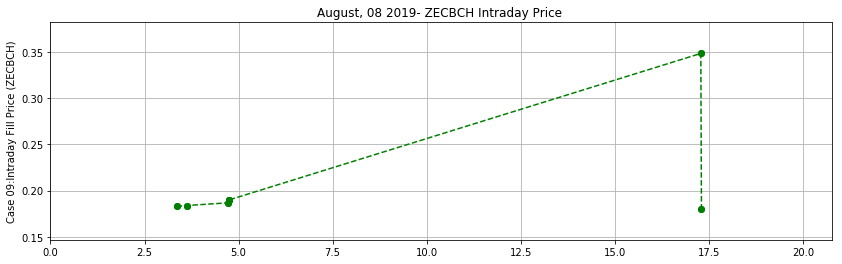

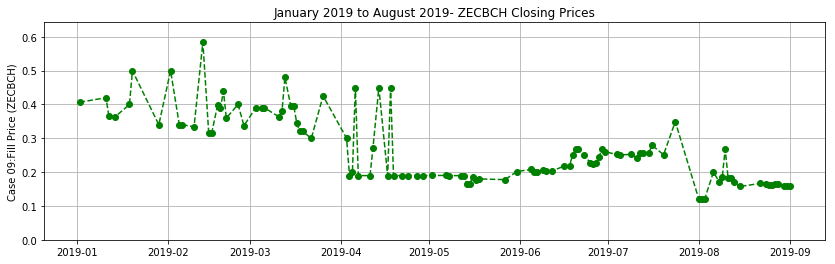

In [19]:
os.chdir('/Users/sqian/Documents/{}_output'.format(alerting_1.strftime("%Y%m")))
writer = pd.ExcelWriter('{}_CaseGroups.xlsx'.format(alerting_1.strftime("%Y%b")), engine='xlsxwriter')


CaseTable.to_excel(writer, 'cases')
finaltable.to_excel(writer, 'alerts')
fig_X0.to_excel(writer, 'f0')
fig_A.to_excel(writer, 'fA')
idee.to_excel(writer, 'IDs')


pd_temp = pd.DataFrame()
for i in PD_dict.keys():
    temp = PD_output(i)
    temp['fig1'].to_excel(writer,'{}.4012{}'.format(i.replace('Case ','C'),'f1'))
    temp['fig2'].to_excel(writer,'{}.4012{}'.format(i.replace('Case ','C'),'f2'))
    temp['fig3'].to_excel(writer,'{}.4012{}'.format(i.replace('Case ','C'),'f3'))
    temp['fig3']['Case'] = i
    pd_temp = pd_temp.append(temp['fig3'])
pd_escalation = pd_temp.loc[(pd_temp['changeRatio'] >= 2.5) & (pd_temp['ticksRatio'] >= 2.5)]
pd_escalation['side'] = pd_escalation['direction'].str.replace('increase','sell').str.replace('decrease','buy')

def round_figures(x, n): 
    if (int(x) | float(x)):
        return round(x, int(n - math.ceil(math.log10(abs(x))))) 
    else:
        return(x)

PD_dict2 = {}
for i in range(0,pd_escalation.shape[0]):
    dir_side_map = {'decrease':'buy','increase':'sell'}
    temp = pd_escalation.reset_index(drop=True).transpose()[i]
    side = temp['side']
    symbol = temp['InstrumentCode']
    date = temp['Date']
    case = temp['Case']
    
    query = """ 
        SELECT account_id, side, trading_pair, sum(price * quantity) as val, sum(quantity) as quant, sum(price * quantity)/sum(quantity) as avg
        from order_fill_event 
        where created::date = '{}' and trading_pair = '{}' and side = '{}'
        group by account_id, trading_pair, side
        """.format(date,symbol,side)

    df = execute_query_data_frame(query,'engine')
    PD_dict2[i] = pd.pivot_table(df, index=['trading_pair','account_id'], columns='side', values=['avg','quant'])
    PD_dict2[i].to_excel(writer,'{}.4012{}'.format(case.replace('Case ','C'),'f4'))
PD_dict2.keys()


for i in UPMtable['CaseNo']:
    test = UPMalerts(UPMtable,i,os.getcwd().format(alerting_1.strftime("%Y%m")),alerting_1,alerting_2)
    test['fig_X1'].to_excel(writer, '{}.1001.f.1'.format(i.replace('Case ','C')))
    test['fig_X2'].to_excel(writer, '{}.1001.f.2'.format(i.replace('Case ','C')))
    test['fig_X3'].to_excel(writer, '{}.1001.f.3'.format(i.replace('Case ','C')))
    test['fig_X4'].to_excel(writer, '{}.1001.f.4'.format(i.replace('Case ','C')))

    
writer.save()

NameError: name 'execute_query_data_frame' is not defined